<a href="https://colab.research.google.com/github/navroz-lamba/DS-Unit-2-Applied-Modeling/blob/master/233_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tanzania Waterpump Dataset

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Wrangle Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

# Split Data

In [ ]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [ ]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Baseline

In [ ]:
print('Baseline Accuracy:', y_val.value_counts(normalize=True).max())

Baseline Accuracy: 0.5430976430976431


# Build Model

## Bagging Model

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

bag_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [ ]:
# Fit on train, score on val
bag_model.fit(X_train, y_train);

In [ ]:
print('Training Accuracy:', bag_model.score(X_train, y_train))
print('Validation Accuracy:', bag_model.score(X_val, y_val))

Training Accuracy: 0.9999579124579124
Validation Accuracy: 0.8135521885521886


## Boosting Model

### in sklearn

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

boost_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    GradientBoostingClassifier(random_state=42)
)

In [ ]:
boost_model.fit(X_train, y_train);

In [ ]:
print('Training Accuracy:', boost_model.score(X_train, y_train))
print('Validation Accuracy:', boost_model.score(X_val, y_val))

Training Accuracy: 0.7591540404040404
Validation Accuracy: 0.7547138047138047


### in XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = make_pipeline(
    OrdinalEncoder(), 
    #SimpleImputer(strategy='median'), 
    XGBClassifier(n_jobs=10, early_stopping_rounds=10)
)

In [ ]:
xgb_model.fit(X_train, y_train);

[09:54:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
print('Training Accuracy:', xgb_model.score(X_train, y_train))
print('Validation Accuracy:', xgb_model.score(X_val, y_val))

Training Accuracy: 0.8635732323232324
Validation Accuracy: 0.8026094276094277


# Feature Importance

"How useful features are for predicting your target."

## Default Feature Importance

In [ ]:
# Working with our bag model
fi = bag_model.named_steps['randomforestclassifier'].feature_importances_
importances = pd.Series(fi, X_train.columns).sort_values(ascending=False)
importances

quantity                     0.082707
longitude                    0.080259
latitude                     0.078752
wpt_name                     0.057207
subvillage                   0.053000
gps_height                   0.043931
day_recorded                 0.036613
ward                         0.036062
waterpoint_type              0.034129
years                        0.032731
population                   0.031210
construction_year            0.030118
funder                       0.029417
waterpoint_type_group        0.028566
installer                    0.025215
amount_tsh                   0.024996
extraction_type_class        0.024988
scheme_name                  0.022967
lga                          0.021653
payment                      0.019834
extraction_type              0.017177
district_code                0.015623
extraction_type_group        0.014481
month_recorded               0.014320
source                       0.013407
region_code                  0.013216
region      

<AxesSubplot:>

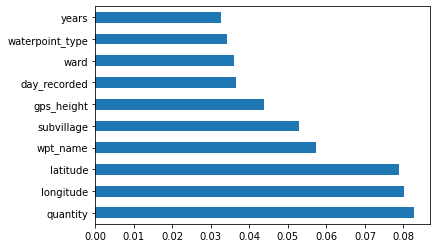

In [ ]:
importances.head(10).plot(kind='barh')

## Drop-Column Importance

1. Train your model on all the data, and check the validation metrics.
2. Remove one column from the data, train the model again, and check the validation metrics.
3. Compare the metrics of the full datasets with those of the drop column.

In [ ]:
col = 'quantity'

# Train with col
with_col = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=6)
)

with_col.fit(X_train, y_train)

print(f'Validation Score with "{col}" Included',
      with_col.score(X_val, y_val))

Validation Score with "quantity"" Included 0.8014309764309764


In [ ]:
# Train without col
without_col = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=6)
)

without_col.fit(X_train.drop(col, axis=1), y_train)

print(f'Validation Score with "{col}" Dropped',
      without_col.score(X_val.drop(col, axis=1), y_val))

Validation Score with "quantity" Dropped 0.7674242424242425


In [ ]:
X_train.shape

(47520, 45)

## Permutation Importance

1. Train your model on the full TRAINING set
2. Choose a column, and shuffle the rows IN YOUR VALIDATION SET
3. See how the validation metrics change

In [ ]:
col

'quantity'

In [ ]:
X_val[col].value_counts()

enough          6619
insufficient    2976
dry             1325
seasonal         806
unknown          154
Name: quantity, dtype: int64

In [ ]:
X_val[col].head(10)

3290     insufficient
47666    insufficient
2538           enough
53117          enough
51817          enough
2109         seasonal
45952          enough
39884          enough
34261             dry
5966              dry
Name: quantity, dtype: object

In [ ]:
np.random.permutation(X_val[col])[:10]

array(['insufficient', 'enough', 'enough', 'enough', 'insufficient',
       'insufficient', 'dry', 'enough', 'enough', 'insufficient'],
      dtype=object)

In [ ]:
X_val_permuted = X_val.copy()
X_val_permuted[col] = np.random.permutation(X_val_permuted[col])

In [ ]:
X_val_permuted[col].head(10)

3290     insufficient
47666        seasonal
2538          unknown
53117          enough
51817          enough
2109           enough
45952    insufficient
39884    insufficient
34261    insufficient
5966     insufficient
Name: quantity, dtype: object

In [ ]:
X_val_permuted[col].value_counts()

enough          6619
insufficient    2976
dry             1325
seasonal         806
unknown          154
Name: quantity, dtype: int64

In [ ]:
model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=6)
)

model.fit(X_train, y_train)

print(f'Validation Score with "{col}" Included',
      model.score(X_val, y_val))

Validation Score with "quantity" Included 0.8014309764309764


In [ ]:
print(f'Validation Score with "{col}" Permuted',
      model.score(X_val_permuted, y_val))

Validation Score with "quantity" Permuted 0.6927609427609428


## "Automating" Permutation Importance

### In sklearn

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
pi = permutation_importance(model, X_val, y_val, n_jobs=10)

In [ ]:
pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [ ]:
pi['importances_mean'].shape

(45,)

In [ ]:
data = {'importances_mean': np.round(pi['importances_mean'], 4),
        'importances_std': pi['importances_std']}

pi_df = pd.DataFrame(data, index=X_val.columns).sort_values(by='importances_mean', ascending=False)
                              
pi_df

,importances_mean,importances_std
quantity,0.1055,0.001839
waterpoint_type,0.0172,0.001672
extraction_type_class,0.0140,0.001722
amount_tsh,0.0118,0.000580
longitude,0.0092,0.001859
latitude,0.0085,0.001752
population,0.0081,0.000449
years,0.0060,0.000885
payment,0.0049,0.001446
extraction_type,0.0049,0.001241


<AxesSubplot:>

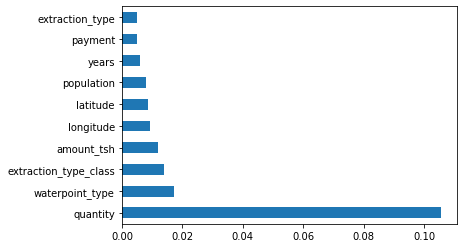

In [ ]:
pi_df['importances_mean'].head(10).plot(kind='barh')

### In eli5

`eli5` can give you a nice visualization, but it doesn't work with pipelines. 

In [ ]:
predictor = model.named_steps['randomforestclassifier']

pipeline = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'))

pipeline.fit(X_train, y_train) # NOTE: fit on training data

XT_val = pipeline.transform(X_val)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    predictor,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(XT_val, y_val)

PermutationImportance(estimator=RandomForestClassifier(n_estimators=20,
                                                       n_jobs=6,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [ ]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.1055 ± 0.0037,quantity
0.0182 ± 0.0036,waterpoint_type
0.0144 ± 0.0011,extraction_type_class
0.0119 ± 0.0026,amount_tsh
0.0086 ± 0.0012,longitude
0.0084 ± 0.0021,years
0.0080 ± 0.0037,latitude
0.0075 ± 0.0012,population
0.0058 ± 0.0031,construction_year
0.0048 ± 0.0023,payment
